# TextEmbedding and Logistic
In this demo, we will go through a sample project to show how to build a project by applying **`TextEmbedding`** and **`Logistic`** Tempaltes. In the project of amazon_reviews, we are trying to decide customers’ sentiment given their contents of the review.

In [1]:
import esppy
esp = esppy.ESP('http://lax95d01.unx.sas.com:40012')

### Step 1 - Data preporcessing

In [2]:
import pandas
train_data = pandas.read_csv('reviews_train_5000.csv', header=None, 
                             names=["id", "title", "content", "rank", "sentiment"])
 
score_data = pandas.read_csv('reviews_test_1000.csv', header=None, 
                             names=["id", "title", "content", "rank", "sentiment"])
 

seed = 1234
n_samples = 5000
train_ratio = 0.5
train_data_sample_pos = train_data.loc[train_data['sentiment'] == 1.0].sample(int(n_samples * train_ratio), random_state=seed)

#since the target variable(sentiment) is highy unbalanced, we are doing resamling here
train_data_sample_neg = train_data.loc[train_data['sentiment'] == 0.0].sample(int(n_samples * (1 - train_ratio)), replace=True, random_state=seed)
train_data_sample = pandas.concat([train_data_sample_pos, train_data_sample_neg])
 
from sklearn.utils import shuffle
train_data_sample_shuffled = shuffle(train_data_sample, random_state=seed)

In [3]:
# train data
train_data_sample_shuffled.head()

,id,title,content,rank,sentiment
4252,1508326,disappointing,I was very excited to finally read this book b...,1,0
4553,8243505,"Dragons, Gems and love in the air - Fantastic!",Let me just start by saying I've read dragon s...,5,1
2635,6092423,Truly A Pleasure,I Am-in love with this cd. This young woman is...,5,1
819,3740945,The Rest of the story after SMITTEN,"If you read Smitten, you'll have to read Crush...",5,1
928,4512125,"Pointless, dull, and ill-written; neither scie...","This is subtitled ""The Chronicles of Hope."" Le...",2,0


In [4]:
# score data
score_data.head()

,id,title,content,rank,sentiment
0,2767458,One of my favorite books!,This book stirs up so many feelings of promise...,5,1
1,2266940,By Far the Best Craft Book I have EVER seen!!!...,I just got the book the otherday and I have al...,5,1
2,4229565,"Well Written, but long","This was a very well written book, especially ...",2,0
3,4932630,Just Bad,Could have been good but someone told this wri...,1,0
4,4589942,Ishamel is older but is he wiser ?,Our boy has become a man. In the course of the...,5,1


### Step 2 - Model Construction

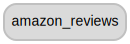

In [5]:
# Create a project 


proj = esp.create_project('amazon_reviews')
esppy.options.display.image_scale = 1
proj

### Step 3: Training Data Stream

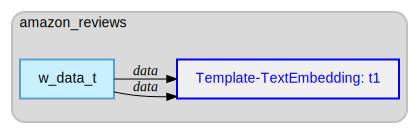

In [6]:
# Define a source window

src = esp.SourceWindow(schema=('id*:int64', 'content:string', 'sentiment:string'),
                       index_type='empty', insert_only=True, autogen_key=True)


# Initialize a TextEmbedding Temaplate

t1 = esp.Template.TextEmbedding('t1')

# Add corresponding edge between windows

src.add_target(t1, role='data')
src.add_target(t1.windows['w_join'], role='data')

proj.windows['w_data_t'] = src
proj.add_template(t1)
proj

### Step 4: Validation Data Stream

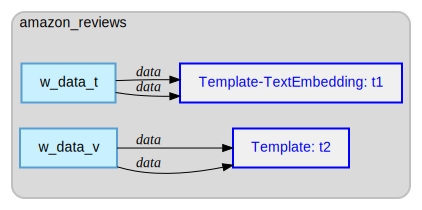

In [7]:
# Define a source window

src2 = esp.SourceWindow(schema=('id*:int64', 'content:string', 'sentiment:string'),
                       index_type='empty', insert_only=True, autogen_key=True)


# Make a copy of t1

t2 = t1.copy('t2', deep=True, internal_only=True)

# Add corresponding edge between windows

src2.add_target(t2, role='data')
src2.add_target(t2.windows['w_join'], role='data')

proj.windows['w_data_v'] = src2
proj.add_template(t2)
proj

### Step 5: Streaming Logistic Regression

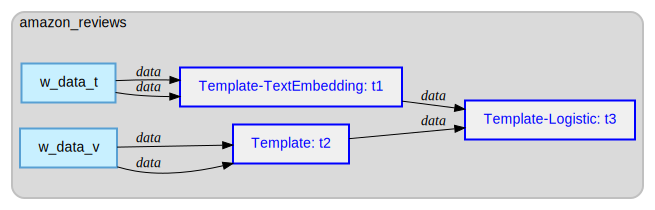

In [8]:
# Initialize a Logis Template

t3 = esp.Template.Logistic('t3')

# add connectivities between corresponding windows

t1.add_target(t3, role='data')
t2.add_target(t3.windows['w_score_logis'], role='data')
proj.add_template(t3)
esppy.options.display.image_scale = 0.65
proj

### Step 6: Online Model Measure

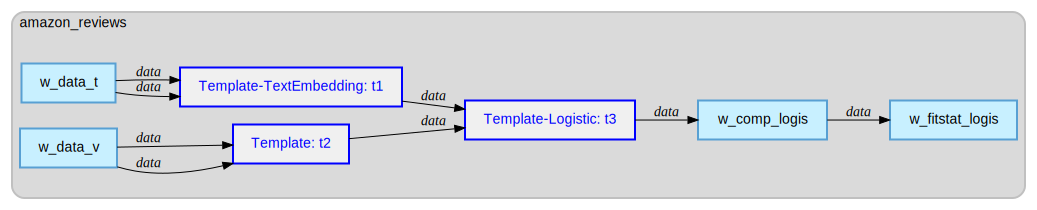

In [9]:
comp_logis = esp.ComputeWindow("w_comp_logis", 
                               schema=['id*:int64', 'sentiment:string',
                                       'predicted_y:double', 'p_1:double', 'p_0:double'])
#predicted_y is actually the predicted P(sentiment = 1)
comp_logis.add_field_expression("tostring(tointeger(sentiment))")
comp_logis.add_field_expression("predicted_y")
comp_logis.add_field_expression("predicted_y")
comp_logis.add_field_expression("1-predicted_y")
 
fitstat_logis = esp.calculate.FitStat(schema=('id*:int64','mceOut:double'),
                                      classLabels='0,1',
                                      windowLength=200)
fitstat_logis.set_inputs(inputs=('p_0:double', 'p_1:double'), 
                         response=('sentiment:string'))
fitstat_logis.set_outputs(mceOut='mceOut:double')
 
proj.windows['w_comp_logis'] = comp_logis
proj.windows['w_fitstat_logis'] = fitstat_logis
t3.add_target(comp_logis, role='data')
comp_logis.add_target(fitstat_logis, role='data')
proj

### Step 7:  Data Streaming and Processing

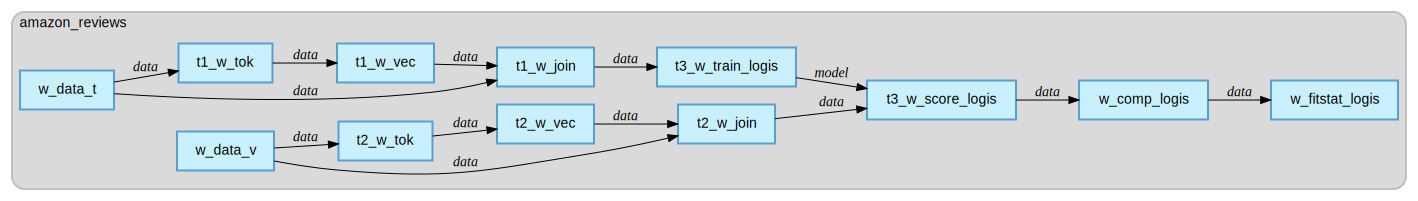

In [10]:
# Load project to esp server

esp.load_project(proj)

In [11]:
#subscribe necessary windows
fitstat_logis.subscribe()

# stream the training data into the engine
src.publish_events(train_data_sample_shuffled, pause=15)
src2.publish_events(score_data, pause=100)

In [12]:
#create a streaming line that visualize mceOut(Mean consequential error) in real time, as new events arrive. 
fitstat_logis.streaming_line('id', ['mceOut'], steps=1000.0, interval=100, max_data=50, y_range=[0,0.8])

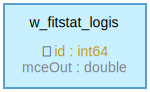

In [14]:
fitstat_logis

### Step 8:  Clean Up

In [26]:
fitstat_logis.unsubscribe()

esp.delete_project(name='amazon_reviews')

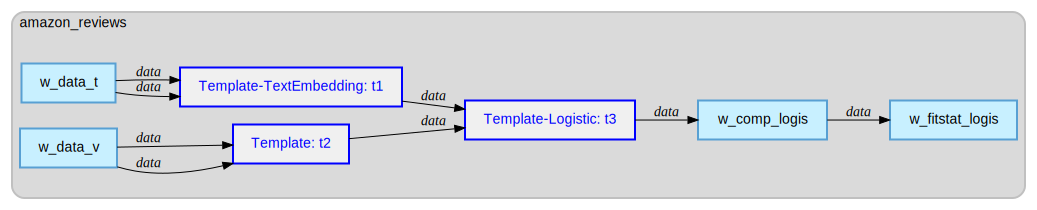

In [11]:
proj

In [44]:
proj.save_xml('amazon.xml')